In [1]:
#import jax
#jax.config.update("jax_enable_x64", True)

In [1]:
import juniper
import scvi
import scanpy as sc
import os
import juniper
import cloudpickle
import functools
import os
import sys
import traceback
from typing import Literal, Optional

import hydra
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import optax
import orbax
import scanpy as sc
import wandb
from omegaconf import DictConfig, OmegaConf
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, otfm
from ott.neural.networks.layers import time_encoder
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm

from ot_pert.metrics import compute_mean_metrics, compute_metrics, compute_metrics_fast
from ot_pert.nets.nets import VelocityFieldWithAttention
from ot_pert.utils import ConditionalLoader
from ot_pert.train_utils import get_preds_from_adata, write_preds_to_adata, reconstruct_data, reconstruct_data_from_vae
import scvi
import juniper
import anndata as ad
import pandas as pd


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [93]:
adata_train = sc.read_h5ad('/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_30_with_scvi_32.h5ad')
adata_test = sc.read_h5ad('/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_30_with_scvi_32.h5ad')
adata_ood = sc.read_h5ad('/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_30_with_scvi_32.h5ad')

In [94]:
obsm_key_data = "X_scVI"
obsm_key_cond_1 = "ecfp_drug_1"
obsm_key_cond_2 = "ecfp_drug_2"

In [95]:
def reconstruct_data_from_vae(model_dir, adata_train, adata):
    """Reconstructs data from projections."""
    model = juniper.latent.model.FactorVI.load(model_dir, adata_train)
    adata.layers["predictions_reconstructed"] = model.get_reconstructed_expression(adata, give_mean=True)
    return adata

In [96]:
def load_data(adata, return_dl: bool):
    """Loads data and preprocesses it based on configuration."""
    dls = []
    data_source = {}
    data_target = {}
    data_source_decoded = {}
    data_target_decoded = {}
    data_conditions = {}
    source = adata[adata.obs["condition"] == "control"].obsm[obsm_key_data]
    source_decoded = adata[adata.obs["condition"] == "control"].X

    for cond in adata.obs["condition"].cat.categories:
        if cond != "control":
            target = adata[adata.obs["condition"] == cond].obsm[obsm_key_data]
            target_decoded = adata[adata.obs["condition"] == cond].X.A
            condition_1 = adata[adata.obs["condition"] == cond].obsm[obsm_key_cond_1]
            condition_2 = adata[adata.obs["condition"] == cond].obsm[obsm_key_cond_2]
            assert np.all(np.all(condition_1 == condition_1[0], axis=1))
            assert np.all(np.all(condition_2 == condition_2[0], axis=1))
            expanded_arr = np.expand_dims(
                np.concatenate((condition_1[0, :][None, :], condition_2[0, :][None, :]), axis=0), axis=0
            )
            conds = np.tile(expanded_arr, (len(source), 1, 1))

            if return_dl:
                dls.append(
                    DataLoader(
                        datasets.OTDataset(
                            datasets.OTData(
                                lin=source,
                                condition=conds,
                            ),
                            datasets.OTData(lin=target),
                        ),
                        batch_size=1024,
                        shuffle=True,
                    )
                )
            else:
                data_source[cond] = source
                data_target[cond] = target
                data_source_decoded[cond] = source_decoded
                data_target_decoded[cond] = target_decoded
                data_conditions[cond] = conds
    if return_dl:
        return ConditionalLoader(dls, seed=0)

    deg_dict = {k: v for k, v in adata.uns["rank_genes_groups_cov_all"].items() if k in data_conditions.keys()}

    return {
        "source": data_source,
        "target": data_target,
        "source_decoded": data_source_decoded,
        "target_decoded": data_target_decoded,
        "conditions": data_conditions,
        "deg_dict": deg_dict,
    }


def data_match_fn(
    src_lin: Optional[jnp.ndarray],
    tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray],
    tgt_quad: Optional[jnp.ndarray],
    *,
    typ: Literal["lin", "quad", "fused"],
    epsilon: float = 1e-2,
    tau_a: float = 1.0,
    tau_b: float = 1.0,
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(
            x=src_lin, y=tgt_lin, scale_cost="mean", epsilon=epsilon, tau_a=tau_a, tau_b=tau_b
        )
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin)
    raise NotImplementedError(f"Unknown type: {typ}.")


def get_mask(x, y, var_names):
    return x[:, [gene in y for gene in var_names]]



In [97]:
#train_data = load_data(adata_train, cfg, return_dl=False) if cfg.training.n_train_samples != 0 else {}
train_data = {}
test_data = {}
#test_data = load_data(adata_test, cfg, return_dl=False) if cfg.training.n_test_samples != 0 else {}
ood_data = load_data(adata_ood,return_dl=False) #if cfg.training.n_ood_samples != 0 else {}
dl = load_data(adata_train, return_dl=True)
comp_metrics_fn = compute_metrics_fast 


In [98]:
vae_model_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/combosciplex_factorvi_test/"
reconstruct_data_fn = lambda adata: reconstruct_data_from_vae(model_dir=vae_model_dir, adata_train=adata_train, adata=adata)

In [99]:
vae = juniper.latent.model.FactorVI.load(vae_model_dir, adata_train)

INFO     File /lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/combosciplex_factorvi_test/model.pt  
         already downloaded                                                                                        


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/ot_pert_geno ...
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/home/icb/dominik.klein/mambaforge/envs/ot_pert_g

Epoch 1/154:   1%|▏                   | 1/154 [00:00<02:11,  1.16it/s, v_num=1, train_loss=675, rec_loss=675, kld_loss=14.7]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/154:   1%|▏                   | 1/154 [00:00<02:12,  1.15it/s, v_num=1, train_loss=675, rec_loss=675, kld_loss=14.7]


In [100]:
adata_train.obsm["X_scVI"][0]

array([-0.49189755, -1.476129  , -0.39328223,  0.48536682,  0.15560514,
       -0.59958494,  0.82758117,  0.03984398,  2.0268652 ,  0.22389063,
       -0.24533376,  0.6328336 ,  0.03190783,  0.11749787, -0.8508341 ,
       -1.3484602 , -0.66296947, -1.5698707 , -0.9352404 , -0.5169273 ,
        1.3213114 ,  0.15231681,  0.6270661 , -1.853128  ,  0.37435183,
       -1.1998657 ,  2.5232925 ,  0.99640566, -1.0628371 , -0.942091  ,
       -0.703772  , -0.28993142], dtype=float32)

In [101]:
adata_train.X[0].data

array([2.4679577, 1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.0295198,
       1.5259349, 1.0295198, 1.0295198, 1.5259349, 1.0295198, 1.0295198,
       1.0295198, 1.0295198, 1.0295198, 1.8561672, 1.0295198, 1.5259349,
       1.8561672, 1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.0295198,
       1.0295198, 1.5259349, 1.5259349, 1.0295198, 2.103998 , 1.0295198,
       1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.5259349,
       1.0295198, 1.5259349, 1.0295198, 1.5259349, 1.0295198, 1.0295198,
       1.5259349, 1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.0295198,
       1.5259349, 1.0295198, 1.0295198, 1.0295198, 1.5259349, 1.0295198,
       1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.0295198,
       1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.0295198, 1.0295198,
       1.5259349, 1.0295198, 1.0295198, 3.6582692, 1.0295198, 1.0295198,
       1.0295198, 2.103998 , 1.0295198, 1.0295198, 1.8561672, 1.0295198,
       1.0295198, 5.8001494, 1.0295198, 1.0295198, 

In [102]:
adata_train.obsm["X_scVI_loaded"] = vae.get_latent_representation(adata_train)

In [103]:
np.abs(adata_train.obsm["X_scVI_loaded"] - adata_train.obsm["X_scVI"]).max()

0.0036802292

In [104]:
batch = next(dl)
output_dim = batch["tgt_lin"].shape[1]
condition_dim = batch["src_condition"].shape[-1]


In [105]:
output_dim

32

In [106]:
vf = VelocityFieldWithAttention(
        num_heads=4,
        qkv_feature_dim=32,
        max_seq_length=2,
        hidden_dims=[2048, 2048, 2048],
        time_dims=[1024, 1024, 1024],
        output_dims=[2048, 2048, 2048] + [output_dim],
        condition_dims=[2048, 2048, 2048],
        dropout_rate=0.0,
        time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
    )

In [107]:
flow=dynamics.ConstantNoiseFlow(0.5)

In [108]:
model = otfm.OTFlowMatching(
        vf,
        flow=flow,
        match_fn=jax.jit(
            functools.partial(
                data_match_fn,
                typ="lin",
                src_quad=None,
                tgt_quad=None,
                epsilon=0.1,
                tau_a=1.0,
                tau_b=1.0,
            )
        ),
        condition_dim=condition_dim,
        rng=jax.random.PRNGKey(13),
        optimizer=optax.MultiSteps(optax.adam(0.0001), 20),
    )

In [109]:
training_logs = {"loss": []}
rng = jax.random.PRNGKey(0)

In [117]:



for it in tqdm(range(10000)):
    rng, rng_resample, rng_step_fn = jax.random.split(rng, 3)
    batch = next(dl)
    batch = jtu.tree_map(jnp.asarray, batch)

    src, tgt = batch["src_lin"], batch["tgt_lin"]
    src_cond = batch.get("src_condition")

    if model.match_fn is not None:
        tmat = model.match_fn(src, tgt)
        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        src, tgt = src[src_ixs], tgt[tgt_ixs]
        src_cond = None if src_cond is None else src_cond[src_ixs]

    model.vf_state, loss = model.step_fn(
        rng_step_fn,
        model.vf_state,
        src,
        tgt,
        src_cond,
    )

    training_logs["loss"].append(float(loss))

100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:36<00:00, 10.04it/s]


In [111]:
data = {"train": train_data, "test": test_data, "ood": ood_data}
log_metrics ={}
var_names = adata_train.var_names

In [115]:
for k, dat in data.items():
    if k == "test":
        continue
    if k == "train":
        continue
    if k == "ood":
        n_samples = -1

    if n_samples != 0:
        if n_samples > 0:
            idcs = np.random.choice(list(list(dat.values())[0]), n_samples)
            dat_source = {k: v for k, v in dat["source"].items() if k in idcs}
            dat_target = {k: v for k, v in dat["target"].items() if k in idcs}
            dat_conditions = {k: v for k, v in dat["conditions"].items() if k in idcs}
            dat_deg_dict = {k: v for k, v in dat["deg_dict"].items() if k in idcs}
            dat_target_decoded = {k: v for k, v in dat["target_decoded"].items() if k in idcs}
        else:
            dat_source = dat["source"]
            dat_target = dat["target"]
            dat_conditions = dat["conditions"]
            dat_deg_dict = dat["deg_dict"]
            dat_target_decoded = dat["target_decoded"]

        prediction = jtu.tree_map(model.transport, dat_source, dat_conditions)
        metrics = jtu.tree_map(comp_metrics_fn, dat_target, prediction)
        mean_metrics = compute_mean_metrics(metrics, prefix=f"{k}_")
        log_metrics.update(mean_metrics)

        adata_with_preds = write_preds_to_adata(prediction, var_names)
        adata_with_decoded_preds = reconstruct_data_fn(adata_with_preds)
        prediction_decoded = get_preds_from_adata(adata_with_decoded_preds)
        #prediction_decoded = jtu.tree_map(lambda x: jnp.log1p(x), prediction_decoded)
        #dat_target_decoded = jtu.tree_map(lambda x: jnp.log1p(x), dat_target_decoded)
        metrics_decoded = jtu.tree_map(comp_metrics_fn, dat_target_decoded, prediction_decoded)
        mean_metrics_decoded = compute_mean_metrics(metrics_decoded, prefix=f"decoded_{k}_")
        log_metrics.update(mean_metrics_decoded)

        #prediction_decoded_deg = jtu.tree_map(mask_fn, prediction_decoded, dat_deg_dict)
        #target_decoded_deg = jax.tree_util.tree_map(mask_fn, dat_target_decoded, dat_deg_dict)
        #metrics_deg = jtu.tree_map(comp_metrics_fn, target_decoded_deg, prediction_decoded_deg)
        #mean_metrics_deg = compute_mean_metrics(metrics_deg, prefix=f"deg_{k}_")
        #log_metrics.update(mean_metrics_deg)


INFO     File /lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/combosciplex_factorvi_test/model.pt  
         already downloaded                                                                                        


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/ot_pert_geno ...
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:11

Epoch 1/154:   1%|▏                   | 1/154 [00:00<02:19,  1.10it/s, v_num=1, train_loss=669, rec_loss=669, kld_loss=14.9]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/154:   1%|▏                   | 1/154 [00:00<02:21,  1.08it/s, v_num=1, train_loss=669, rec_loss=669, kld_loss=14.9]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [116]:
log_metrics

{'ood_r_squared': 0.7073661810188574,
 'ood_e_distance': 4.532236745028269,
 'ood_mmd_distance': 0.013364936744566899,
 'decoded_ood_r_squared': 0.9377282031931505,
 'decoded_ood_e_distance': 12.27322344403721,
 'decoded_ood_mmd_distance': 0.061209325048705354}

In [113]:
log_metrics

{'ood_r_squared': 0.6953079442834128,
 'ood_e_distance': 4.855208865429633,
 'ood_mmd_distance': 0.01349200758351563,
 'decoded_ood_r_squared': 0.9435833120111029,
 'decoded_ood_e_distance': 11.154396511744263,
 'decoded_ood_mmd_distance': 0.05831209003944101}

In [32]:
log_metrics

{'ood_r_squared': 0.7069743884001227,
 'ood_e_distance': 4.662178506060937,
 'ood_mmd_distance': 0.013058335759497266,
 'decoded_ood_r_squared': -0.08357349413739876,
 'decoded_ood_e_distance': 954643.6521063086,
 'decoded_ood_mmd_distance': 0.26893759123049676}

In [23]:
log_metrics

{'ood_r_squared': 0.7069743884001227,
 'ood_e_distance': 4.662178506060937,
 'ood_mmd_distance': 0.013058335759497266,
 'decoded_ood_r_squared': -0.10406976515064481,
 'decoded_ood_e_distance': 972646.0373078706,
 'decoded_ood_mmd_distance': 1.0007973670959474}

In [29]:
adata_with_preds.layers["predictions_reconstructed"].sum(axis=1)

array([16.46878 , 16.46878 , 16.46878 , ..., 16.444353, 16.444353,
       16.444353], dtype=float32)

In [26]:
adata_with_decoded_preds.layers['predictions_reconstructed'].sum(axis=1)

array([16.46878 , 16.46878 , 16.46878 , ..., 16.444353, 16.444353,
       16.444353], dtype=float32)

In [229]:
adata_with_decoded_preds.layers['predictions_reconstructed']

array([[4.5234270e+00, 3.6571667e-01, 1.6416606e+00, ..., 3.6706331e-03,
        4.0473230e-03, 1.1039276e-02],
       [3.7327564e+00, 1.1164610e+00, 3.4929240e+00, ..., 2.8138164e-02,
        2.2657894e-02, 5.7850849e-02],
       [3.5144508e+00, 7.2496480e-01, 1.6295165e+00, ..., 4.7402955e-03,
        4.5824097e-03, 1.3417094e-02],
       ...,
       [3.1763098e+00, 1.8836889e-01, 4.0572637e-01, ..., 2.3004480e-03,
        3.2096603e-03, 1.7317552e-02],
       [2.1518092e+00, 2.0580825e-01, 6.2917137e-01, ..., 4.4852062e-03,
        3.9990982e-03, 1.1459285e-02],
       [4.6349325e+00, 1.0675223e-01, 6.9818068e-01, ..., 2.7636946e-03,
        3.9794096e-03, 1.4103306e-02]], dtype=float32)

In [239]:
prediction_decoded['Cediranib+PCI-34051'].shape

(500, 2000)

In [240]:
dat_target_decoded['Cediranib+PCI-34051'].shape

(2161, 2000)

In [243]:
dat_target_decoded['Cediranib+PCI-34051'].sum(axis=0)

Array([856.6217   ,  32.534775 , 142.27313  , ...,   2.5231566,
         0.       ,   1.5797136], dtype=float32)

In [244]:
prediction_decoded['Cediranib+PCI-34051'].sum(axis=0)

Array([649.3513  , 315.0412  , 493.2681  , ...,   6.104162,   6.214764,
        11.280672], dtype=float32)

In [118]:
true =dat_target_decoded['Cediranib+PCI-34051'].mean(axis=0)

In [119]:
pred= prediction_decoded['Cediranib+PCI-34051'].mean(axis=0)

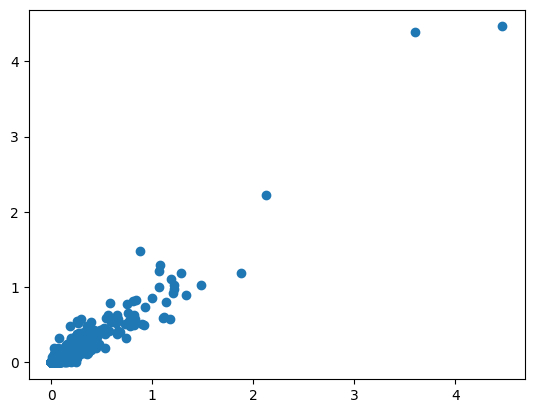

In [120]:
import matplotlib.pyplot as plt
plt.scatter(true, pred)

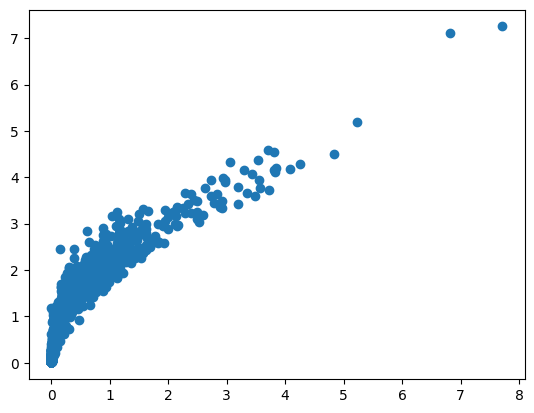

In [257]:
import matplotlib.pyplot as plt
plt.scatter(true, pred)

In [121]:
from sklearn.metrics import pairwise_distances, r2_score
r2_score(true, pred)

0.9054820133532604

In [122]:
adata_with_decoded_preds.X = adata_with_decoded_preds.layers['predictions_reconstructed']
sc.pp.log1p(adata_with_decoded_preds)

In [123]:
sc.pp.pca(adata_with_decoded_preds)

In [124]:
sc.pp.neighbors(adata_with_decoded_preds)

In [125]:
sc.tl.umap(adata_with_decoded_preds)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


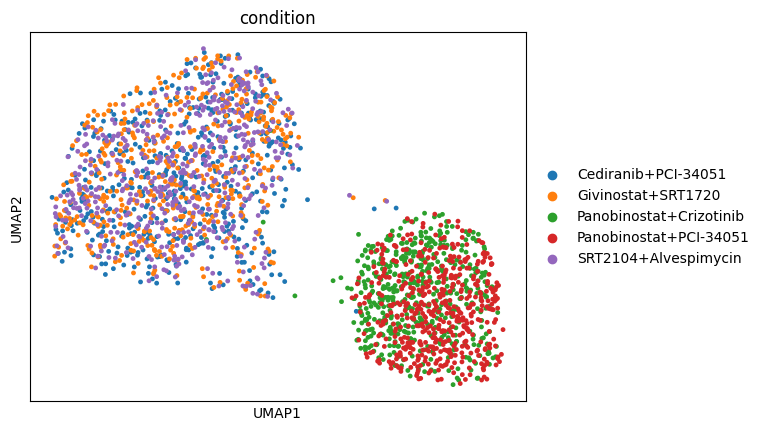

In [126]:
sc.pl.umap(adata_with_decoded_preds, color="condition")

In [235]:
jtu.tree_map(comp_metrics_fn, dat_target_decoded, prediction_decoded)

{'Cediranib+PCI-34051': {'r_squared': -0.19798584356389282,
  'e_distance': 1930.5436274277658,
  'mmd_distance': 0.062462695239939116},
 'Givinostat+SRT1720': {'r_squared': 0.028318819332833645,
  'e_distance': 1596.574265973665,
  'mmd_distance': 0.08245686734744595},
 'Panobinostat+Crizotinib': {'r_squared': 0.24759811103938056,
  'e_distance': 1125.705947706471,
  'mmd_distance': 0.11247039697074494},
 'Panobinostat+PCI-34051': {'r_squared': 0.32635931193117473,
  'e_distance': 959.2087404460005,
  'mmd_distance': 0.13337759634699373},
 'SRT2104+Alvespimycin': {'r_squared': -0.564639479989349,
  'e_distance': 2092.594492482603,
  'mmd_distance': 0.08227230785520116}}

In [236]:
jtu.tree_map(comp_metrics_fn, prediction_decoded, dat_target_decoded)

{'Cediranib+PCI-34051': {'r_squared': 0.512420874102757,
  'e_distance': 1930.543627427765,
  'mmd_distance': 0.0624626952254251},
 'Givinostat+SRT1720': {'r_squared': 0.5995062468474106,
  'e_distance': 1596.5742659736666,
  'mmd_distance': 0.08245686735714723},
 'Panobinostat+Crizotinib': {'r_squared': 0.6253592409628052,
  'e_distance': 1125.7059477064686,
  'mmd_distance': 0.11247039691253728},
 'Panobinostat+PCI-34051': {'r_squared': 0.6830570943527327,
  'e_distance': 959.2087404460008,
  'mmd_distance': 0.13337759634653898},
 'SRT2104+Alvespimycin': {'r_squared': 0.4831915398225163,
  'e_distance': 2092.594492482604,
  'mmd_distance': 0.08227230785520234}}

In [224]:
metrics_decoded

{'Cediranib+PCI-34051': {'r_squared': -0.0893806109440789,
  'e_distance': 1755.527237949825,
  'mmd_distance': 0.07675622977289247},
 'Givinostat+SRT1720': {'r_squared': -0.00968061374086604,
  'e_distance': 1659.0113147551542,
  'mmd_distance': 0.07575723889215169},
 'Panobinostat+Crizotinib': {'r_squared': 0.23513174579273588,
  'e_distance': 1144.3575074679525,
  'mmd_distance': 0.10458293634800005},
 'Panobinostat+PCI-34051': {'r_squared': 0.3636052167536764,
  'e_distance': 906.1736479077404,
  'mmd_distance': 0.13872250668934308},
 'SRT2104+Alvespimycin': {'r_squared': -0.6186921879292191,
  'e_distance': 2164.8862063150164,
  'mmd_distance': 0.07505230861216934}}

In [223]:
adata_with_decoded_preds.layers["predictions_reconstructed"].sum(axis=1)

array([10000.001, 10000.   , 10000.   , ...,  9999.999, 10000.   ,
       10000.   ], dtype=float32)

In [207]:
sc.pp.normalize_total(adata_with_decoded_preds, layer="predictions_reconstructed", target_sum=1e4)

In [208]:
adata_with_decoded_preds.layers["predictions_reconstructed"].sum(axis=1)

array([10000.   , 10000.   , 10000.001, ..., 10000.   , 10000.   ,
       10000.   ], dtype=float32)

In [195]:
log_metrics

{'ood_r_squared': 0.7801299116436177,
 'ood_e_distance': 1.4324369344651529,
 'ood_mmd_distance': 0.015822493393837553,
 'decoded_ood_r_squared': -0.08677430102905177,
 'decoded_ood_e_distance': 231.59342371925771,
 'decoded_ood_mmd_distance': 0.9320690193472323,
 'deg_ood_r_squared': -0.7247913556535718,
 'deg_ood_e_distance': 107.10111997401063,
 'deg_ood_mmd_distance': 0.8733031232651364}

In [86]:
log_metrics

{'ood_r_squared': 0.7842028923450262,
 'ood_e_distance': 1.3548466167007003,
 'ood_mmd_distance': 0.015998996811201018,
 'decoded_ood_r_squared': -0.13469629649125445,
 'decoded_ood_e_distance': 255.7969349417634,
 'decoded_ood_mmd_distance': 0.912808176785124,
 'deg_ood_r_squared': -0.8931161564023717,
 'deg_ood_e_distance': 118.29540442214451,
 'deg_ood_mmd_distance': 0.8719442534775366}

0.0

In [96]:
(adata_with_decoded_preds.layers['predictions_reconstructed'] == adata_with_decoded_preds_first.layers['predictions_reconstructed']).all()

True

In [76]:
log_metrics

{'ood_r_squared': 0.270474295767878,
 'ood_e_distance': 4.165022842811548,
 'ood_mmd_distance': 0.03753945026316312,
 'decoded_ood_r_squared': -0.13469629649125445,
 'decoded_ood_e_distance': 255.7969349417634,
 'decoded_ood_mmd_distance': 0.912808176785124,
 'deg_ood_r_squared': -0.8931161564023717,
 'deg_ood_e_distance': 118.29540442214451,
 'deg_ood_mmd_distance': 0.8719442534775366}

In [82]:
#adata_with_preds_first = adata_with_preds.copy()

In [84]:
#adata_with_decoded_preds_first = adata_with_decoded_preds.copy()

In [88]:
adata_with_preds_first.obsm["X_scVI"]

array([[-0.02451822, -0.02075379,  0.01366155, ...,  0.05424838,
        -0.04635515, -0.0303812 ],
       [-0.02726309, -0.01211593,  0.01812962, ...,  0.01336192,
        -0.00723635,  0.0141642 ],
       [-0.0243336 , -0.02205633, -0.02520159, ...,  0.04065448,
        -0.02014731, -0.01748908],
       ...,
       [ 0.01042244,  0.01742857,  0.01444016, ..., -0.01895677,
         0.04331066,  0.03248708],
       [ 0.0591699 , -0.01408406, -0.05043986, ..., -0.16192771,
         0.04463919,  0.02816241],
       [-0.00347759, -0.03321035, -0.03458762, ...,  0.00274747,
        -0.01764908, -0.00637134]], dtype=float32)

In [91]:
adata_with_preds_first.layers

Layers with keys: predictions_reconstructed

In [97]:
sc.pp.neighbors(adata_with_preds, use_rep="X_scVI")

In [98]:
sc.tl.umap(adata_with_preds)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


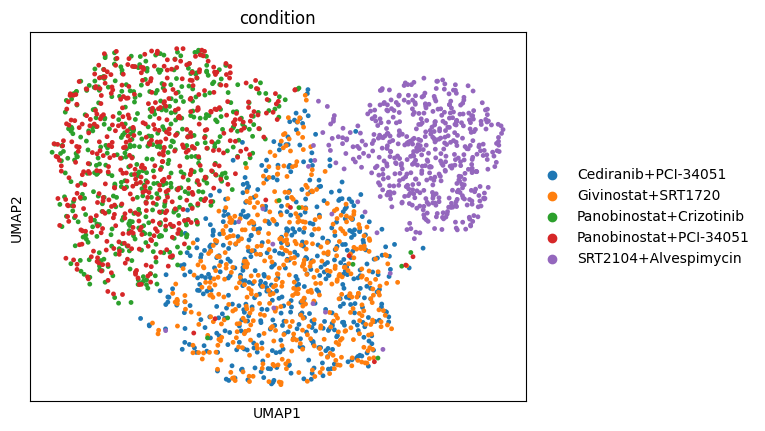

In [99]:
sc.pl.umap(adata_with_preds,color='condition')

In [ ]:
def reconstruct_data_from_vae2(model_dir, adata_train, adata):
    """Reconstructs data from projections."""
    import cloudpickle
    with open(vae_model_dir, 'rb') as f:
        vae_model = cloudpickle.load(f)
    adata.layers["predictions_reconstructed"] = model.get_reconstructed_expression(adata, give_mean=True)
    return adata

In [ ]:
vae_model = 

In [100]:
with open(vae_model_dir, 'rb') as f:
    vae_model = cloudpickle.load(f)

In [114]:
adata_with_preds.obsm["X_scVI2"] = adata_with_preds.obsm["X_scVI"].copy()
adata_with_preds_first.obsm["X_scVI2"] = adata_with_preds_first.obsm["X_scVI"].copy()

In [121]:
out1 = vae_model.get_reconstructed_expression(adata_with_preds, use_rep="X_scVI2", give_mean=False)

In [122]:
out0 = vae_model.get_reconstructed_expression(adata_with_preds_first, use_rep="X_scVI2", give_mean=False)

In [123]:
out0.shape, out1.shape

((2500, 2000), (2500, 2000))

In [124]:
out0==out1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [127]:
out1.max()

0.5075448

In [131]:
out3 = vae_model.get_reconstructed_expression(adata_ood, give_mean=True)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [134]:
adata_ood.obsm['X_scVI']

array([[ 0.00047844, -0.09257184, -0.01386847, ...,  0.04978434,
         0.0143034 , -0.03197372],
       [-0.00058267, -0.0313235 ,  0.04676039, ...,  0.03458041,
        -0.03787329,  0.00110668],
       [ 0.00242753, -0.05767409,  0.03099006, ...,  0.04136315,
        -0.03033207, -0.02036739],
       ...,
       [ 0.0172124 ,  0.00754233,  0.03883788, ..., -0.00829974,
         0.02419957,  0.00793552],
       [ 0.06480331, -0.0243636 , -0.02559904, ..., -0.15442234,
         0.02362221,  0.01023024],
       [ 0.00097588, -0.04235889, -0.00827855, ...,  0.01010471,
        -0.03863306, -0.03048207]], dtype=float32)

In [135]:
adata_with_preds.obsm["X_scVI"]

array([[-0.01164189, -0.02307781, -0.00951836, ...,  0.03999869,
        -0.04611316, -0.03273366],
       [-0.01170112, -0.01539776,  0.00169662, ..., -0.00163188,
        -0.01520961,  0.00476973],
       [-0.00836806, -0.01567194, -0.04784247, ...,  0.01681142,
        -0.01056119, -0.01126883],
       ...,
       [ 0.01349637,  0.01885681, -0.02044486, ..., -0.06549746,
         0.0624928 ,  0.04402945],
       [ 0.05811578, -0.02885798, -0.07461418, ..., -0.20309603,
         0.05574144,  0.03978169],
       [-0.00323562, -0.04820522, -0.05740761, ..., -0.04709813,
        -0.00740947, -0.00260788]], dtype=float32)

In [151]:
juniper.latent.model.FactorVI.setup_anndata(adata_with_preds)

In [136]:
adata_ood.obsm['X_scVI2'] = adata_with_preds.obsm["X_scVI"]

ValueError: Value passed for key 'X_scVI2' is of incorrect shape. Values of obsm must match dimensions ('obs',) of parent. Value had shape (2500,) while it should have had (8896,).

In [139]:
adata_ood.obsm['X_scVI'].shape

(8896, 128)

In [140]:
adata_with_preds.obsm["X_scVI"].shape

(2500, 128)

In [141]:
adata_ood_tmp= adata_ood[:2500].copy()

In [142]:
out4 = vae_model.get_reconstructed_expression(adata_ood_tmp, give_mean=True)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [143]:
out4

array([[2.7078378e-01, 1.0480001e-02, 6.2929466e-02, ..., 1.8755652e-04,
        2.0050694e-04, 7.9497992e-04],
       [3.0403327e-02, 7.5058918e-03, 3.2147799e-02, ..., 1.2422005e-04,
        1.1619313e-04, 4.8636945e-04],
       [2.3643793e-01, 3.5467740e-02, 3.8471807e-02, ..., 2.6508659e-04,
        3.0577404e-04, 1.3255771e-03],
       ...,
       [1.4967763e-01, 2.0515602e-03, 4.6784434e-01, ..., 1.5421033e-04,
        6.6959095e-04, 4.0493472e-04],
       [1.1363076e-01, 4.3343720e-03, 7.4977897e-02, ..., 1.2930905e-04,
        2.8670003e-04, 2.8740001e-04],
       [2.2979569e-01, 1.0613986e-02, 8.7370741e-01, ..., 4.1705463e-04,
        2.6953164e-03, 3.4840361e-03]], dtype=float32)

In [154]:
adata_ood_tmp.obsm['X_scVI2'] = adata_with_preds.obsm["X_scVI"]

In [155]:
out4 = vae_model.get_reconstructed_expression(adata_ood_tmp, give_mean=True, use_rep="X_scVI2")

In [156]:
out4

array([[1.97715238e-01, 2.04331018e-02, 8.18116888e-02, ...,
        2.01696646e-04, 2.19477311e-04, 5.92209108e-04],
       [1.47046030e-01, 6.29880354e-02, 1.63284272e-01, ...,
        1.77124224e-03, 1.42218021e-03, 3.45131801e-03],
       [2.42930368e-01, 5.86373247e-02, 1.17791876e-01, ...,
        3.52184492e-04, 3.40814149e-04, 9.49336041e-04],
       ...,
       [1.23206608e-01, 8.18961207e-03, 1.70289129e-02, ...,
        9.36734577e-05, 1.36032788e-04, 7.25771533e-04],
       [5.26047945e-02, 5.62480744e-03, 1.62480678e-02, ...,
        1.13402966e-04, 1.04128732e-04, 3.00904707e-04],
       [4.83201951e-01, 1.29270665e-02, 8.12841207e-02, ...,
        3.09614814e-04, 4.53431683e-04, 1.55882677e-03]], dtype=float32)

In [157]:
adata_ood_tmp

AnnData object with n_obs × n_vars = 2500 × 2000
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type', 'cell_line', 'smiles_drug_1', 'smiles_drug_2', 'ood', 'is_ood', '_scvi_batch'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pathway1_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'rank_genes_groups_cov_all', 'umap'
    obsm: 'X_pca', 'X_pca_from_raw_log1p', 'X_scVI', 'X_umap', 'ecfp_drug_1', 'ecfp_drug_2', 'reconstruction', 'X_scVI2'
    varm: 'X_train_mean'
    layers: 'centered_Xlog1p', 'counts'

In [163]:
adata_ood_tmp.obs['sample'].values[0]

'sciPlex_theis'

In [160]:
adata_with_preds.obs['_scvi_batch'] = 0

In [164]:
adata_with_preds.obs = adata_ood_tmp.obs

In [171]:
adata_with_preds.X = np.ones(adata_with_preds.X.shape) * 1000000

In [174]:
out5 = vae_model.get_reconstructed_expression(adata_with_preds, give_mean=False, use_rep="X_scVI")

In [176]:
out5.sum(axis=1)

array([1.        , 1.        , 1.        , ..., 1.        , 0.99999994,
       1.0000001 ], dtype=float32)

In [113]:
np.abs(adata_with_preds.obsm["X_scVI"] - adata_with_preds_first.obsm["X_scVI"]).mean()

0.038261674

In [ ]:
adata_with_preds.obsm["X_scVI3"]

In [177]:
vae_model.get_latent_library_size()

AttributeError: 'FactorVI' object has no attribute 'get_latent_library_size'

In [179]:
adata_test.X.sum(axis=1).mean()

515.6184

In [181]:
di

109320.33

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


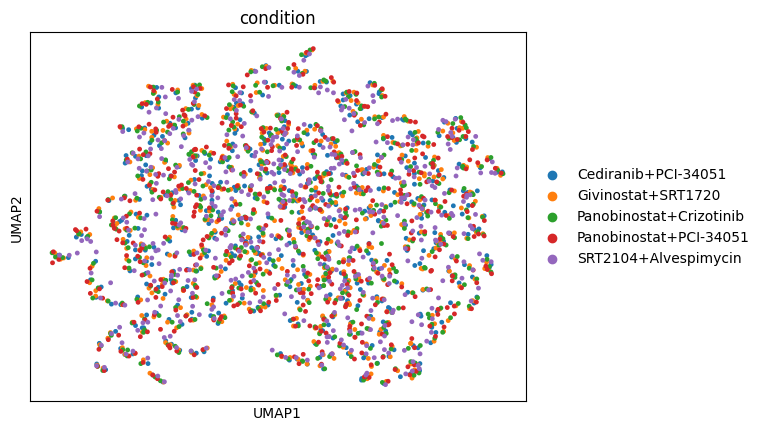

In [81]:
sc.pl.umap(adata_with_preds,color='condition')

In [2]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/combosciplex_factorvi_test/combosciplex_vae_128.pkl", 'rb') as f:
    loaded_object = cloudpickle.load(f)

In [3]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex"

In [47]:
adata_train.obsm#["X_scVI"].shape

AxisArrays with keys: X_pca, X_pca_from_raw_log1p, X_scVI, X_umap, ecfp_drug_1, ecfp_drug_2, reconstruction

In [48]:
adata_train = sc.read(os.path.join(output_dir, "adata_train_300_with_scvi_128.h5ad"))
adata_test = sc.read(os.path.join(output_dir, "adata_test_300_with_scvi_128.h5ad"))
adata_ood = sc.read(os.path.join(output_dir, "adata_ood_300_with_scvi_128.h5ad")) 

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [8]:
adata_ood.obsm["reconstruction2"] = loaded_object.get_reconstructed_expression(adata_ood, give_mean=True)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


2024-07-02 19:15:24.503351: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [14]:
import numpy as np
np.abs((adata_ood.obsm["reconstruction2"] - adata_ood.obsm["reconstruction"])).mean()

0.00017406586

In [23]:
adata_ood.X = adata_ood.obsm["reconstruction2"]

In [24]:
sc.pp.normalize_total(adata_ood)
sc.pp.log1p(adata_ood)
sc.pp.pca(adata_ood)

In [26]:
sc.pp.neighbors(adata_ood)
sc.tl.umap(adata_ood)


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


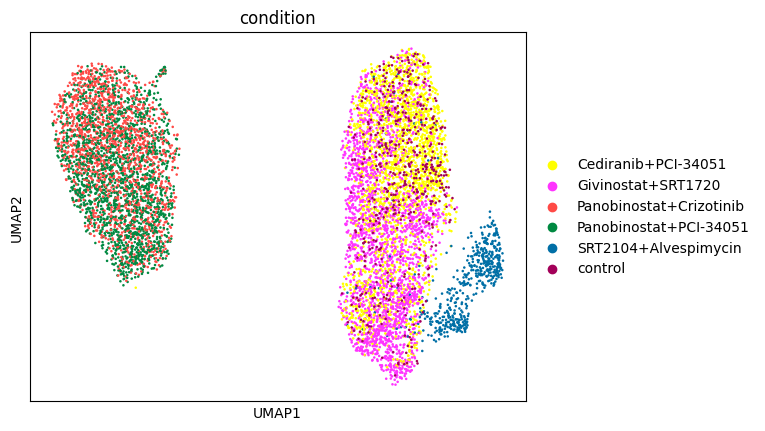

In [27]:
sc.pl.umap(adata_ood, color="condition")